# Шахвалиева Юлиана

### Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score, roc_curve, log_loss
import time
import xlearn as xl
from tqdm.auto import tqdm

### Чтение входных данных

In [3]:
data = pd.read_csv('../data/data.csv')
data.head()

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,banner_id0,rate0,g0,coeff_sum0,banner_id1,rate1,g1,coeff_sum1,impressions,clicks
0,2021-09-27 00:01:30.000000,0,0,5664530014561852622,0,0,0,1240,0.067,0.035016,-7.268846,0,0.010,0.049516,-5.369901,1,1
1,2021-09-26 22:54:49.000000,1,1,5186611064559013950,0,0,1,1,0.002,0.054298,-2.657477,269,0.004,0.031942,-4.449220,1,1
2,2021-09-26 23:57:20.000000,2,2,2215519569292448030,3,0,0,2,0.014,0.014096,-3.824875,21,0.014,0.014906,-3.939309,1,1
3,2021-09-27 00:04:30.000000,3,3,6262169206735077204,0,1,1,3,0.012,0.015232,-3.461357,99,0.006,0.050671,-3.418403,1,1
4,2021-09-27 00:06:21.000000,4,4,4778985830203613115,0,1,0,4,0.019,0.051265,-4.009026,11464230,6.790,0.032005,-2.828797,1,1


### Удаление ненужных колонок

In [4]:
useless_clmns = ['banner_id0', 'banner_id1', 'rate0', 'rate1', 'g0', 'g1', 'coeff_sum0', 'coeff_sum1']
data = data.drop(useless_clmns, axis=1)

data.head()

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,impressions,clicks
0,2021-09-27 00:01:30.000000,0,0,5664530014561852622,0,0,0,1,1
1,2021-09-26 22:54:49.000000,1,1,5186611064559013950,0,0,1,1,1
2,2021-09-26 23:57:20.000000,2,2,2215519569292448030,3,0,0,1,1
3,2021-09-27 00:04:30.000000,3,3,6262169206735077204,0,1,1,1,1
4,2021-09-27 00:06:21.000000,4,4,4778985830203613115,0,1,0,1,1


### Анализ входных данных

In [2]:
# Функция для форматирования текста
def get_pretty_title(text):
    return ('\033[1m' + text + '\033[0m').center(55)

# Функция для форматирования вывода в консоль
def pretty_print(text, values):
    print(f'\n\n{get_pretty_title(text)}', values, sep='\n\n')

# Функция для первичного анализа входных данных
def pre_analysis(data: pd.DataFrame):  
    
    # Размер датасета
    shape = data.shape
    pretty_print('Размер датасета:', shape)
    
    # Просмотр типов входных данных
    dtypes = data.dtypes
    pretty_print('Типы данных:', dtypes)
    
    # Подсчет описательных статистик для всех признаков
    statistics = data.describe()
    pretty_print('Описательные статистики:', statistics)
    
    # Поиск пропусков в данных
    nan_values = data.isna().sum()
    pretty_print('Пропуски в данных:', nan_values)
    
    # Подсчет количества дубликатов
    count_duplicates = data.duplicated().sum()
    pretty_print('Количество дубликатов:', count_duplicates)
    
    # Распределение целевой переменной по классам
    count_target_value = data['clicks'].value_counts()
    pretty_print('Распределение целевой переменной:', count_target_value) 

In [6]:
# Применение функции для первичного анализа входных данных
pre_analysis(data)



                Размер датасета:               

(15821472, 9)


                  Типы данных:                 

date_time          object
zone_id             int64
banner_id           int64
oaid_hash           int64
campaign_clicks     int64
os_id               int64
country_id          int64
impressions         int64
clicks              int64
dtype: object


            Описательные статистики:           

            zone_id     banner_id     oaid_hash  campaign_clicks  \
count  1.582147e+07  1.582147e+07  1.582147e+07     1.582147e+07   
mean   8.152679e+01  3.816483e+02  4.610505e+18     6.238540e-01   
std    1.632448e+02  3.959386e+02  2.663858e+18     9.249152e+00   
min    0.000000e+00  0.000000e+00  1.116911e+12     0.000000e+00   
25%    1.400000e+01  5.200000e+01  2.297977e+18     0.000000e+00   
50%    1.900000e+01  2.170000e+02  4.614236e+18     0.000000e+00   
75%    6.000000e+01  6.110000e+02  6.914243e+18     0.000000e+00   
max    3.443000e+03  1.632000e+03  9.2233

#### Выводы из проведенного первичного анализа: 
+ Все признаки, кроме одного имеют целочисленный тип данных. Тип признака `data_time` при дальнейшем препроцессинге необходимо поменять;
+ Все признаки кроме `data_time`, `impressions`, `clicks` - категориальные;
+ Признак `impressions` везде имеет значение `1`, поэтому перед построением модели его необходимо удалить;
+ Количество входнных данных: `15821472`;
+ В данных нет пропусков;
+ В данных присутствуют дубликаты, от них необходимо избавиться;
+ Целевая переменная распределена неравномерно, предсставителей одного класса сильно больше, чем представителей другого.

In [7]:
# Функция для очистки данных
def clean(data: pd.DataFrame) -> pd.DataFrame:
    # Изменение типа признака date_time
    data['date_time'] = pd.to_datetime(data['date_time'])
    
    # Удаление признака impressions
    data = data.drop(['impressions'], axis=1)
    
    # Удаление дубликатов
    data = data.drop_duplicates()
    
    return data

In [8]:
# Применение функции для очистки данных
data = clean(data)

In [9]:
# Повтороное применение функции для первичного анализа входных данных с целью проверки результатов очистки данных
pre_analysis(data)



                Размер датасета:               

(15753367, 8)


                  Типы данных:                 

date_time          datetime64[ns]
zone_id                     int64
banner_id                   int64
oaid_hash                   int64
campaign_clicks             int64
os_id                       int64
country_id                  int64
clicks                      int64
dtype: object


            Описательные статистики:           

            zone_id     banner_id     oaid_hash  campaign_clicks  \
count  1.575337e+07  1.575337e+07  1.575337e+07     1.575337e+07   
mean   8.135618e+01  3.820874e+02  4.610635e+18     6.047690e-01   
std    1.631649e+02  3.961850e+02  2.663867e+18     8.886853e+00   
min    0.000000e+00  0.000000e+00  1.116911e+12     0.000000e+00   
25%    1.400000e+01  5.200000e+01  2.298197e+18     0.000000e+00   
50%    1.900000e+01  2.200000e+02  4.614380e+18     0.000000e+00   
75%    6.000000e+01  6.130000e+02  6.914148e+18     0.000000e+00   
max

In [10]:
# Функция для построения гистограм распределения переменных
def make_plots(data, features):
    plt.figure(figsize=(15, 10))
    
    for k, feature in enumerate(features):

        plt.subplot(3, 4, k + 1)
        
        if feature == 'date_time':
            plt.hist(data[feature].dt.date, bins=10)
        else:
            plt.hist(data[feature], bins=10)
            
        plt.title(feature)
        plt.grid()
    
    plt.show()
    
# Функция для проведения анализа распределения переменных после очистки данных
def post_analysis(data):
    data = data.drop(['clicks'], axis=1)
    
    features = list(data.columns)
    
    for feature in features:
        if feature == 'date_time':
            pretty_print(f'Распределение переменной {feature}', data[feature].dt.date.value_counts())
        else:
            pretty_print(f'Распределение переменной {feature}', data[feature].value_counts())
    
    make_plots(data, features)



       Распределение переменной date_time      

2021-09-26    3089323
2021-09-29    2411743
2021-09-27    2354952
2021-09-28    2293469
2021-10-02    2121766
2021-09-30    1844194
2021-10-01    1637919
2021-09-01          1
Name: date_time, dtype: int64


        Распределение переменной zone_id       

17      2265418
14      1633478
12       731609
0        706494
19       692862
         ...   
2186          1
2188          1
2518          1
2199          1
3443          1
Name: zone_id, Length: 3444, dtype: int64


       Распределение переменной banner_id      

22      610056
361     385784
3       285888
18      260891
21      245324
         ...  
1501         1
1503         1
1504         1
1507         1
1632         1
Name: banner_id, Length: 1633, dtype: int64


       Распределение переменной oaid_hash      

308174966294367527     5243
2890718152668627077    2511
3375698397737628939    1953
7778402214309164700    1947
777813202827899938     1871
                       

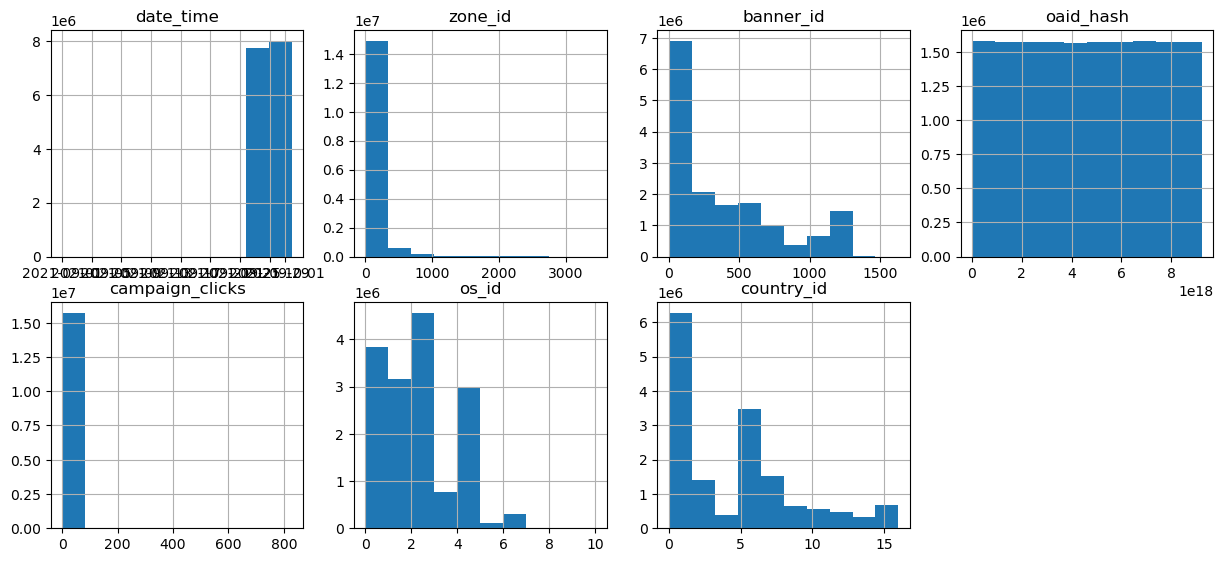

In [11]:
# Применение функции для анализа распределения переменных после очистки данных
post_analysis(data)

#### Выводы из проведенного вторичного анализа анализа: 
+ Переменные распределены неравномерно;
+ В данных имеются выбросы, от которых необходимо избавиться.

In [12]:
# Функция для удаления выбросов в данных. Выбросы определялись на основании проведенного вторичного анализа
def drop_outliers(data):
    data = data[data['date_time'].dt.date != pd.Timestamp('2021-09-01').date()]
    data = data[data['zone_id'] < 300]
    data = data[data['banner_id'] < 1400]
    data = data[data['campaign_clicks'] < 30]
    data = data[data['os_id'] < 7]
    
    return data

In [13]:
# Применение функции для удаления выбросов
data = drop_outliers(data)

In [14]:
# Повтороное применение функции для первичного анализа входных данных после удаления выбросов
pre_analysis(data)



                Размер датасета:               

(14611593, 8)


                  Типы данных:                 

date_time          datetime64[ns]
zone_id                     int64
banner_id                   int64
oaid_hash                   int64
campaign_clicks             int64
os_id                       int64
country_id                  int64
clicks                      int64
dtype: object


            Описательные статистики:           

            zone_id     banner_id     oaid_hash  campaign_clicks  \
count  1.461159e+07  1.461159e+07  1.461159e+07     1.461159e+07   
mean   4.553065e+01  3.855410e+02  4.611596e+18     2.999802e-01   
std    5.993765e+01  3.996956e+02  2.662345e+18     1.311357e+00   
min    0.000000e+00  0.000000e+00  1.116911e+12     0.000000e+00   
25%    1.400000e+01  5.200000e+01  2.301902e+18     0.000000e+00   
50%    1.800000e+01  2.210000e+02  4.615519e+18     0.000000e+00   
75%    5.000000e+01  6.130000e+02  6.912863e+18     0.000000e+00   
max



       Распределение переменной date_time      

2021-09-26    2854914
2021-09-27    2223122
2021-09-29    2190728
2021-09-28    2068105
2021-10-02    1932116
2021-09-30    1764105
2021-10-01    1578503
Name: date_time, dtype: int64


        Распределение переменной zone_id       

17     2264971
14     1633114
12      731544
0       706280
19      692411
        ...   
106         12
209         11
293         11
296          3
229          1
Name: zone_id, Length: 300, dtype: int64


       Распределение переменной banner_id      

22      542256
361     370706
3       284633
21      236092
52      223341
         ...  
1321         1
1323         1
1331         1
1336         1
1364         1
Name: banner_id, Length: 1382, dtype: int64


       Распределение переменной oaid_hash      

8212556321845734673    1717
5023283936586308615    1389
2890718152668627077    1304
9147167173199190030    1129
3443481738804143922    1002
                       ... 
2068382946845035887       1
8

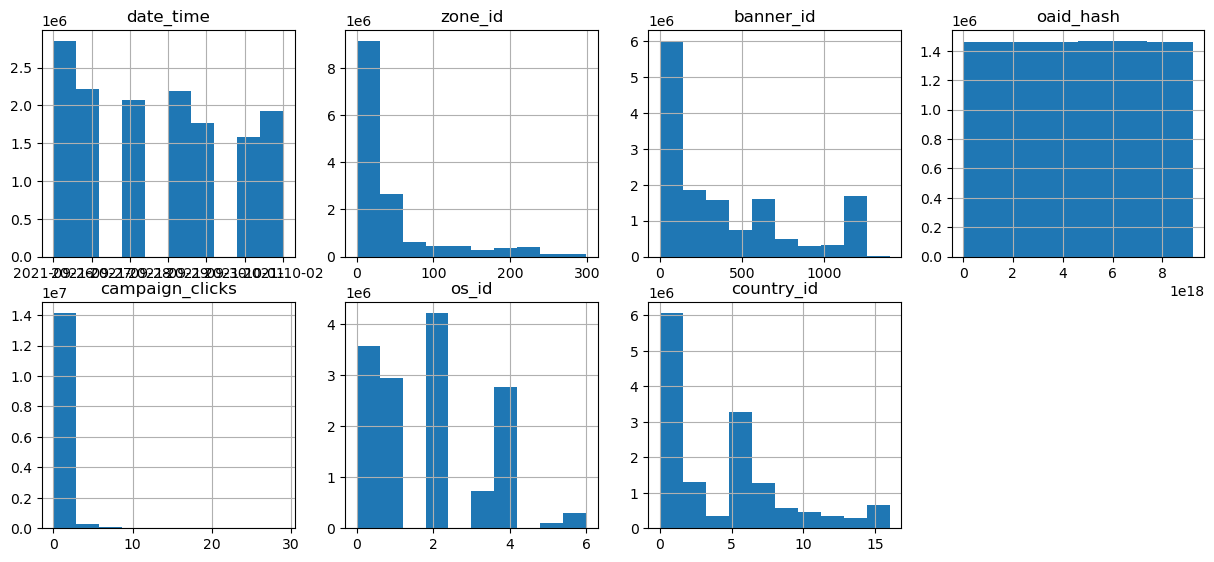

In [15]:
# Повторное применение функции для анализа распределения переменных после удаления выбросов
post_analysis(data)

### Предобработка данных

In [16]:
# Функция для построения фичей и разделения выборки на тренировочную и тестовую части
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:    
    # Создание фичей на основе признака date_time: категориальный признак, отвечающий за день недели 
    # и категориальный признак, отвечающий за время суток: утро, день, вечер, ночь
    data['day'] = data['date_time'].dt.dayofweek
    data['time'] = pd.cut(data['date_time'].dt.hour, bins=[-1, 7, 12, 18, 24], labels=[0, 1, 2, 3])
    
    # Разделение выборки на тестовую и тренировочную часть: в тестовую попали наблюдения из последнего дня   
    last_day = data['date_time'].dt.date.max()

    data_train = data[data['date_time'].dt.date < last_day]
    data_test = data[data['date_time'].dt.date >= last_day]

    y_train = data_train.clicks
    X_train = data_train.drop(['clicks', 'date_time'], axis=1)

    y_test = data_test.clicks
    X_test = data_test.drop(['clicks', 'date_time'], axis=1)

    return X_train, X_test, y_train, y_test

In [17]:
# Применение функции для построения фичей и разделения выборки на тренировочную и тестовую части
X_train, X_test, y_train, y_test = feature_engineering(data)

# Вывод размеров полученных выборок
shapes = f'X_train: {X_train.shape}\t\tX_test: {X_test.shape}\ny_train: {y_train.shape}\t\ty_test: {y_test.shape}'
pretty_print('Полученные размерности: ', shapes)



            Полученные размерности:            

X_train: (12679477, 8)		X_test: (1932116, 8)
y_train: (12679477,)		y_test: (1932116,)


In [18]:
# Сохранение выборок для воспроизводимости
X_train.to_csv('../data/X_train.txt', index=False)
X_test.to_csv('../data/X_test.txt', index=False)
y_train.to_csv('../data/y_train.txt', index=False)
y_test.to_csv('../data/y_test.txt', index=False)

In [3]:
# Загрузка сохраненных выборок 
X_train = pd.read_csv('../data/X_train.txt')
X_test = pd.read_csv('../data/X_test.txt')
y_train = pd.read_csv('../data/y_train.txt')
y_test = pd.read_csv('../data/y_test.txt')

In [19]:
# Функция для сохранения данных в нужном для построения модели формате (libffm)
def save_in_libffm(X, y, file_name):
    lines = []

    for label, (i, X_row) in tqdm(zip(y, X.iterrows()), total=len(y)):
        line = f'{label} '

        for X_col, X_data in enumerate(X_row):
            line += f'{X_col}:{i}:{X_data} '

        lines.append(line)
        
    libffm_data = '\n'.join(lines)

    with open(file_name, 'w') as file:
        file.write(libffm_data)

In [20]:
# Применение функции для сохранения данных в нужном для построения модели формате
save_in_libffm(X_train, y_train, '../data/libffm_train.txt')

  0%|          | 0/12679477 [00:00<?, ?it/s]

In [21]:
# Применение функции для сохранения данных в нужном для построения модели формате
save_in_libffm(X_test, y_test, '../data/libffm_test.txt')

  0%|          | 0/1932116 [00:00<?, ?it/s]

### Построение модели

Для решения поставленной задачи будет построена модель FFM с помощью библиотеки `xlearn`. В качестве филдов будут взяты данные одной природы, то есть one-hot encoding категориальных фичей будут объединены в один филд.

Из-за этого объединения не нужно проводить процедуру one-hot encoding (но она подразумевается).

С помощью алгоритма подбора гиперпараметров `Grid Search` будет подобрана регуляризация с использованием `log-loss` и `auc` в качестве метрик качества.

In [27]:
# Функция для создания модели FFM, возвращающая log-loss 
def create_model(parameter, i):
    ffm_model = xl.create_ffm()
    
    ffm_model.setTrain('../data/libffm_test.txt')
    ffm_model.fit(parameter, f'model_{i}.out')
    
    ffm_model.setTest('../data/libffm_test.txt')
    ffm_model.setSigmoid()
    ffm_model.predict(f'model_{i}.out', f'pred_{i}.txt')
    
    y_pred = pd.read_csv(f'pred_{i}.txt', names=['clicks'])
    loss = log_loss(y_test, y_pred)
    
    return loss

In [28]:
# Функция для запуска обучения и подбора гиперпараметров
def cv():
    # Включение таймера
    start = time.time()
    
    # Инициализация гиперпараметра размерности для FFM
    parameters = {'task': ['binary'], 
                  'k': [4, 6, 8],
                  'lr': [0.2],
                  'lambda': [0.0001]}
    
    # Инициализация grid search   
    grid_search = ParameterGrid(parameters)
    
    # Установка начальных значений для последующего перебора
    min_loss = np.inf
    num_best_model = -1
    best_parameter = None

    # Подбор гиперпараметров
    for i, parameter in enumerate(grid_search):
        pretty_print(f'Параметры ({i + 1}/{3}):', parameter)
        loss = create_model(parameter, i + 1)
    
    if loss < min_loss:
        min_loss = loss
        num_best_model = i
        best_parameter = parameter
    
    # Остановка таймера
    end = time.time()
    spent_time = round((end - start) / 60, 2)
    
    # Вывод подобранных параметров
    pretty_print('Best parameters:', best_parameter)
    
    # Затраченное время
    pretty_print('Time spent (min):', spent_time)  

    return num_best_model

In [29]:
# Поиск лучшей модели
num_best_model = cv()   

best_model_name = f'model_{num_best_model}.out'
y_pred = pd.read_csv(f'pred_{num_best_model}.txt', names=['clicks'])



                Параметры (1/3):               

{'k': 4, 'lambda': 0.0001, 'lr': 0.2, 'task': 'binary'}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[ WARNING    ] Validation file not found, xLearn has already disable early-stopping.
[------------] xLearn uses 4 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (../data/libffm_test.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 15821470
[------------] Number of Field: 8
[------------] Time cost for reading problem:

[------------] Binary file (../data/libffm_test.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 15821470
[------------] Number of Field: 8
[------------] Time cost for reading problem: 2.65 (sec)
[ ACTION     ] Initialize model ...
[------------] Model size: 7.66 GB
[------------] Time cost for model initial: 9.28 (sec)
[ ACTION     ] Start to train ...
[------------] Epoch      Train log_loss     Time cost (sec)
[   10%      ]     1            0.157668                1.09
[   20%      ]     2            0.152443                1.20
[   30%      ]     3            0.148073                1.04
[   40%      ]     4            0.144050                0.85
[   50%      ]     5            0.140548                0.84
[   60%      ]     6            0.137560                0.84
[   70%      ]     7            0.134810                0.82
[   80%      ]     8            0.132200                0.79
[   90%      ]     9            0.129751                0.92


### Тестирование итоговой модели

С помощью итоговой модели будет сделано предсказание для последнего дня из выборки (для тестовых данных, полученных ранее). Будут посчитаны метрики качества, которые предлагается сравнить с baseline-моделью: средним предсказанием.

In [40]:
# Функция для получения средних по выборке предсказаний
def get_baseline(y_test):
    return pd.Series([y_test.mean()] * len(y_test))

# Функция для тестирования обученной модели на последнем дне из датасета
def test_model(best_model_name, y_test, y_pred):
    # Получение средних по выборке предсказаний
    y_mean = get_baseline(y_test)

    # Вычисление log-loss и auc
    loss = log_loss(y_test, y_pred)
    loss_mean = log_loss(y_test, y_mean)

    auc = roc_auc_score(y_test, y_pred)
    auc_mean = roc_auc_score(y_test, y_mean)

    metrics = f'Log-loss = {loss}\tAUC = {auc}'
    metrics_mean = f'Log-loss = {loss_mean}\tAUC = {auc_mean}'

    pretty_print('Метрики построенной модели:', metrics)
    pretty_print('Метрики бейзлайна:', metrics_mean)

In [41]:
# Запуск тестирования построенной модели
test_model(best_model_name, y_test, y_pred)

/home/yuliana/anaconda3/lib/python3.11/site-packages/sklearn/utils/_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
/home/yuliana/anaconda3/lib/python3.11/site-packages/sklearn/utils/_array_api.py:380: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)




          Метрики построенной модели:          

Log-loss = 0.12562267676511296	AUC = 0.7913196420981193


               Метрики бейзлайна:              

Log-loss = 0.15738754956668136	AUC = 0.5


In [26]:
# Копирование итогов домашнего задания 1 с целью сравнения полученых результатов
metrics = f'Log-loss = {0.1364647116255024}\tAUC = {0.7804670051638557}'

pretty_print('Метрики из ДЗ_1: ', metrics)



               Метрики из ДЗ_1:                

Log-loss = 0.1364647116255024	AUC = 0.7804670051638557


Полученные результаты лучше, чем в предыдущем домашнем задании по показателям log-loss и auc.